# Unsupervised Learning / Data Analytics 1
The purpose of this notebook is to .....analyse user behaviour and network characteristics.
outliers in every section individual

## Structure
1. Overview
1. Post Analysis
    1. Post Count
2. User Analysis
    1. Number of unique users
    2. Most active users
    3. Distribution of user activity
    4. Temporal patterns in user activity (e.g., daily/weekly trends)
    5. Identification of outlier users
3. Network Analysis
    1. Network density and sparsity
    2. Community detection using Louvain algorithm
    3. Centrality measures (e.g., degree, betweenness, closeness)
    4. Identification of key users (bridges, hubs, and influencers)
    5. Clustering coefficients and neighborhood connectivity

## Summarized Results
- The network is globally sparse, with low average clustering, meaning most users are not well-connected to their neighbors.
- Within this sparse structure, some communities form tightly-knit clusters, which the Louvain algorithm identifies.
- Central users, such as `1010626427`, act as bridges connecting these otherwise independent communities, creating a sparse but connected global network.
- User activity distribution is highly skewed, with a few users contributing disproportionately to the total activity.

# Overview

# Every Import should happen in the first line of code! Janina wants it like this!

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
#TODO: Add the necessary import to work with the data

In [3]:
from scripts.preprocess_data import *
from scripts.preprocess_lemmatizer import preprocess_lemmatizer
#TODO: Let's not change the original data in the df. I want to add a column
#  like 'preprocessed_text'. Refactoring Required! Need to add the 
# preprocessing into this Notebook
df = load_data()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Simon.Luttmann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Simon.Luttmann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load the data

In [1]:
from scripts.preprocess_data import *
# Load and normalize the df
df = load_data()
df = normalize_data(df)

[nltk_data] Downloading package stopwords to /Users/leori/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/leori/nltk_data...


In [46]:
df = load_data()
df = normalize_data(df)

In [2]:
primary = '#333F48'

# Post Analysis

### Post Length

In [4]:
# Use original posts without lemmetization and further preprocessing to evaluate the realistic post length
original_posts = load_data()

Overview with average

Average text length: 198.93
Median text length: 195


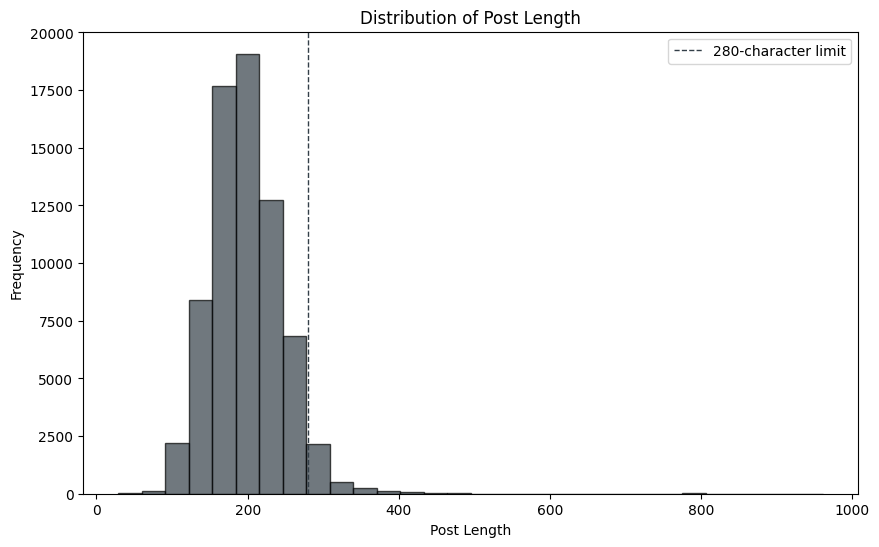

In [50]:
import matplotlib.pyplot as plt
# Compute the length of each text
original_posts['text_length'] = original_posts['text'].apply(len)

# Calculate average and median text length
average_length = original_posts['text_length'].mean()
median_length = original_posts['text_length'].median()

print(f"Average text length: {round(average_length,2)}")
print(f"Median text length: {int(median_length)}")

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
plt.hist(original_posts['text_length'], bins=30, edgecolor='k', alpha=0.7, color=primary)
plt.axvline(x=280, color=primary, linestyle='--', linewidth=1, label='280-character limit')
plt.title('Distribution of Post Length')
plt.xlabel('Post Length')
plt.ylabel('Frequency')
plt.legend()  # Add legend to explain the vertical line
plt.show()

- The average post length of approximately 199 characters suggests the dataset likely originates from X (formerly Twitter), where free users have a 280-character limit. Notably, as of October 31, 2024, X Premium subscribers could post tweets up to 25,000 characters, indicating the presence of longer posts in the dataset.

TODO: Do we want to include An outlier analysis of long posts? I have the code in the other notebook, but it may be too full to the include it here too. What do you think?

### Post Frequency

In [ ]:
# Calculate the number of unique users
unique_users = df['user_id'].nunique()
print(f"Number of unique users: {unique_users}")

# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate overall post count
total_posts = df.shape[0]
print(f"Total number of posts: {total_posts}")

# Calculate the average tweets per user
average_tweets_per_user = total_posts / unique_users
print(f"Average tweets per user: {average_tweets_per_user:.2f}")

Number of unique users: 46755
Total number of posts: 70260
Average tweets per user: 1.50


- With an average of **1.50 posts per user**, most users are likely **casual participants**, indicating moderate engagement, while a small number of highly active users (or bots) may be driving the overall post count.

### Temporal Analysis

Check the date range of the data

In [29]:
print(f"Earliest timestamp: {df['timestamp'].min()}, Latest timestamp: {df['timestamp'].max()}")

Earliest timestamp: 2024-10-31 00:00:00, Latest timestamp: 2024-10-31 23:59:59


- The data basis is limited to one day (31st October 2024), which makes a temporal analysis (e.g. about content drift) over multiple days, months or years impossible.

TODO: Add temporal analysis with number of posts per second and hour + interpretation for spam and time-zone

In [5]:
df['datetime'] = pd.to_datetime(df['timestamp'])

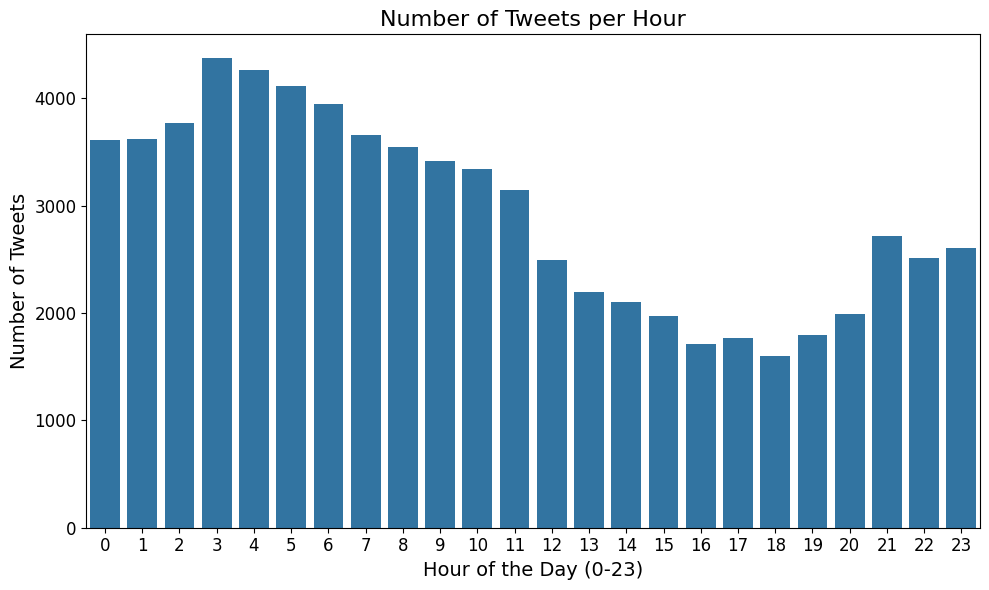

In [ ]:
hourly_tweets= df['datetime'].dt.hour.value_counts().sort_index()
hours = hourly_tweets.index
tweet_counts = hourly_tweets.values

# Set up the figure
plt.figure(figsize=(10, 6))
sns.barplot(x=hours, y=tweet_counts)
plt.title("Number of Tweets per Hour", fontsize=16)
plt.xlabel("Hour of the Day (0-23)", fontsize=14)
plt.ylabel("Number of Tweets", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

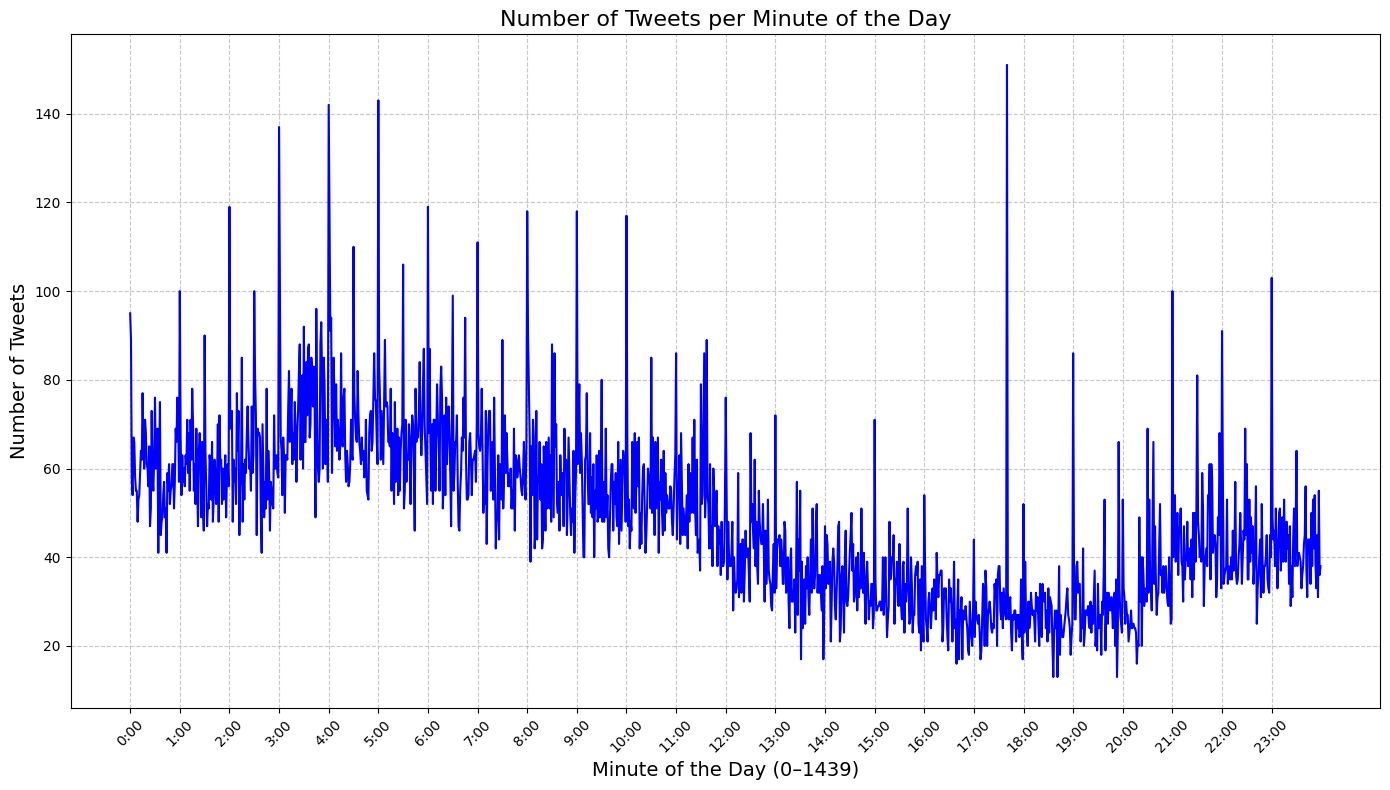

In [10]:
minute_tweets = (df['datetime'].dt.hour * 60 + df['datetime'].dt.minute).value_counts().sort_index()
minutes = minute_tweets.index
tweet_counts = minute_tweets.values

plt.figure(figsize=(14, 8))
sns.lineplot(x=minutes, y=tweet_counts, color='blue', linewidth=1.5)
plt.title("Number of Tweets per Minute of the Day", fontsize=16)
plt.xlabel("Minute of the Day (0–1439)", fontsize=14)
plt.ylabel("Number of Tweets", fontsize=14)
plt.xticks(ticks=range(0, 1440, 60), labels=[f"{i}:00" for i in range(24)], rotation=45)
plt.grid(visible=True, which="major", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

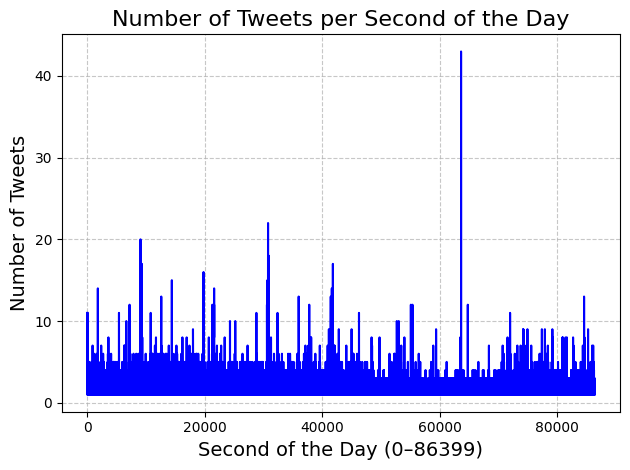

In [ ]:
second_tweet = (
    df['datetime'].dt.hour * 3600 +
    df['datetime'].dt.minute * 60 +
    df['datetime'].dt.second
).value_counts().sort_index()
seconds = second_tweet.index
tweet_counts = second_tweet.values

sns.lineplot(x=seconds, y=tweet_counts, color='blue', linewidth=1.5)
plt.title("Number of Tweets per Second of the Day", fontsize=16)
plt.xlabel("Second of the Day (0–86399)", fontsize=14)
plt.ylabel("Number of Tweets", fontsize=14)
plt.grid(visible=True, which="major", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
second_tweet.nlargest(5)

datetime
63653    43
63654    34
63652    26
30785    22
9065     20
Name: count, dtype: int64

In [26]:
df[(df['datetime'].dt.hour * 3600 +
    df['datetime'].dt.minute * 60 +
    df['datetime'].dt.second) == 63653]["text"].head(5)

56463    Bring comfort dogs to every university lecture...
56464    Bring comfort dogs to every university lecture...
56465    Bring comfort dogs to every university lecture...
56466    Bring comfort dogs to every university lecture...
56467    Bring comfort dogs to every university lecture...
Name: text, dtype: object

In [28]:
specific_text = df['text'].iloc[56463]
print(specific_text)

Bring comfort dogs to every university lecture! 🎓❤🐶️ Let's make our campuses fluffy again! Join the movement! #PawsForLearning #UniMS


In [29]:
print(f"This Text is {len(df[df['text'] == specific_text])} times in the dataset")

This Text is 130 times in the dataset


### Topic Modelling

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Convert the text df into a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['text'])

# Define the specific values for n_components
topic_values = [3, 6, 10, 15]

# Initialize variables to store results
best_num_topics = None
best_model = None
best_perplexity = np.inf  # Lower perplexity is better

# Loop through the specified number of topics
for n_topics in topic_values:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(doc_term_matrix)  # Fit the model on the full dataset
    perplexity = lda.perplexity(doc_term_matrix)  # Evaluate perplexity

    print(f"Number of Topics: {n_topics}, Perplexity: {perplexity:.2f}")

    # Update the best model if this one is better
    if perplexity < best_perplexity:
        best_num_topics = n_topics
        best_model = lda
        best_perplexity = perplexity

# Output the best number of topics and corresponding perplexity
print(f"\nBest Number of Topics: {best_num_topics}, Perplexity: {best_perplexity:.2f}")

# Get the top words for each topic from the best model
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[-num_top_words:]]))

# Display topics using the best model
num_top_words = 10  # Number of top words to display per topic
feature_names = vectorizer.get_feature_names_out()
display_topics(best_model, feature_names, num_top_words)

Number of Topics: 3, Perplexity: 5396.52
Number of Topics: 6, Perplexity: 5088.83
Number of Topics: 10, Perplexity: 4713.48
Number of Topics: 15, Perplexity: 4589.52

Best Number of Topics: 15, Perplexity: 4589.52
Topic 1:
epic, ywagner, check, excited, shoutout, ready, katherine, amazing, wait, para
Topic 2:
got, hey, marketing, small, like, social, medium, need, check, business
Topic 3:
energy, like, youtube, latest, logo, politics, news, check, trump, business
Topic 4:
essay, assignment, make, got, health, need, vaccine, help, let, covid
Topic 5:
game, let, political, look, hey, people, business, time, like, politics
Topic 6:
time, truth, world, let, right, change, history, climate, politics, science
Topic 7:
wellbeing, wellness, issue, secretary, public, mental, check, care, healthcare, health
Topic 8:
love, social, bbmas, army, voting, btsbbmas, artist, let, vote, yhawkins
Topic 9:
million, global, new, climatecrisis, climateaction, vibe, let, time, dont, make
Topic 10:
technology

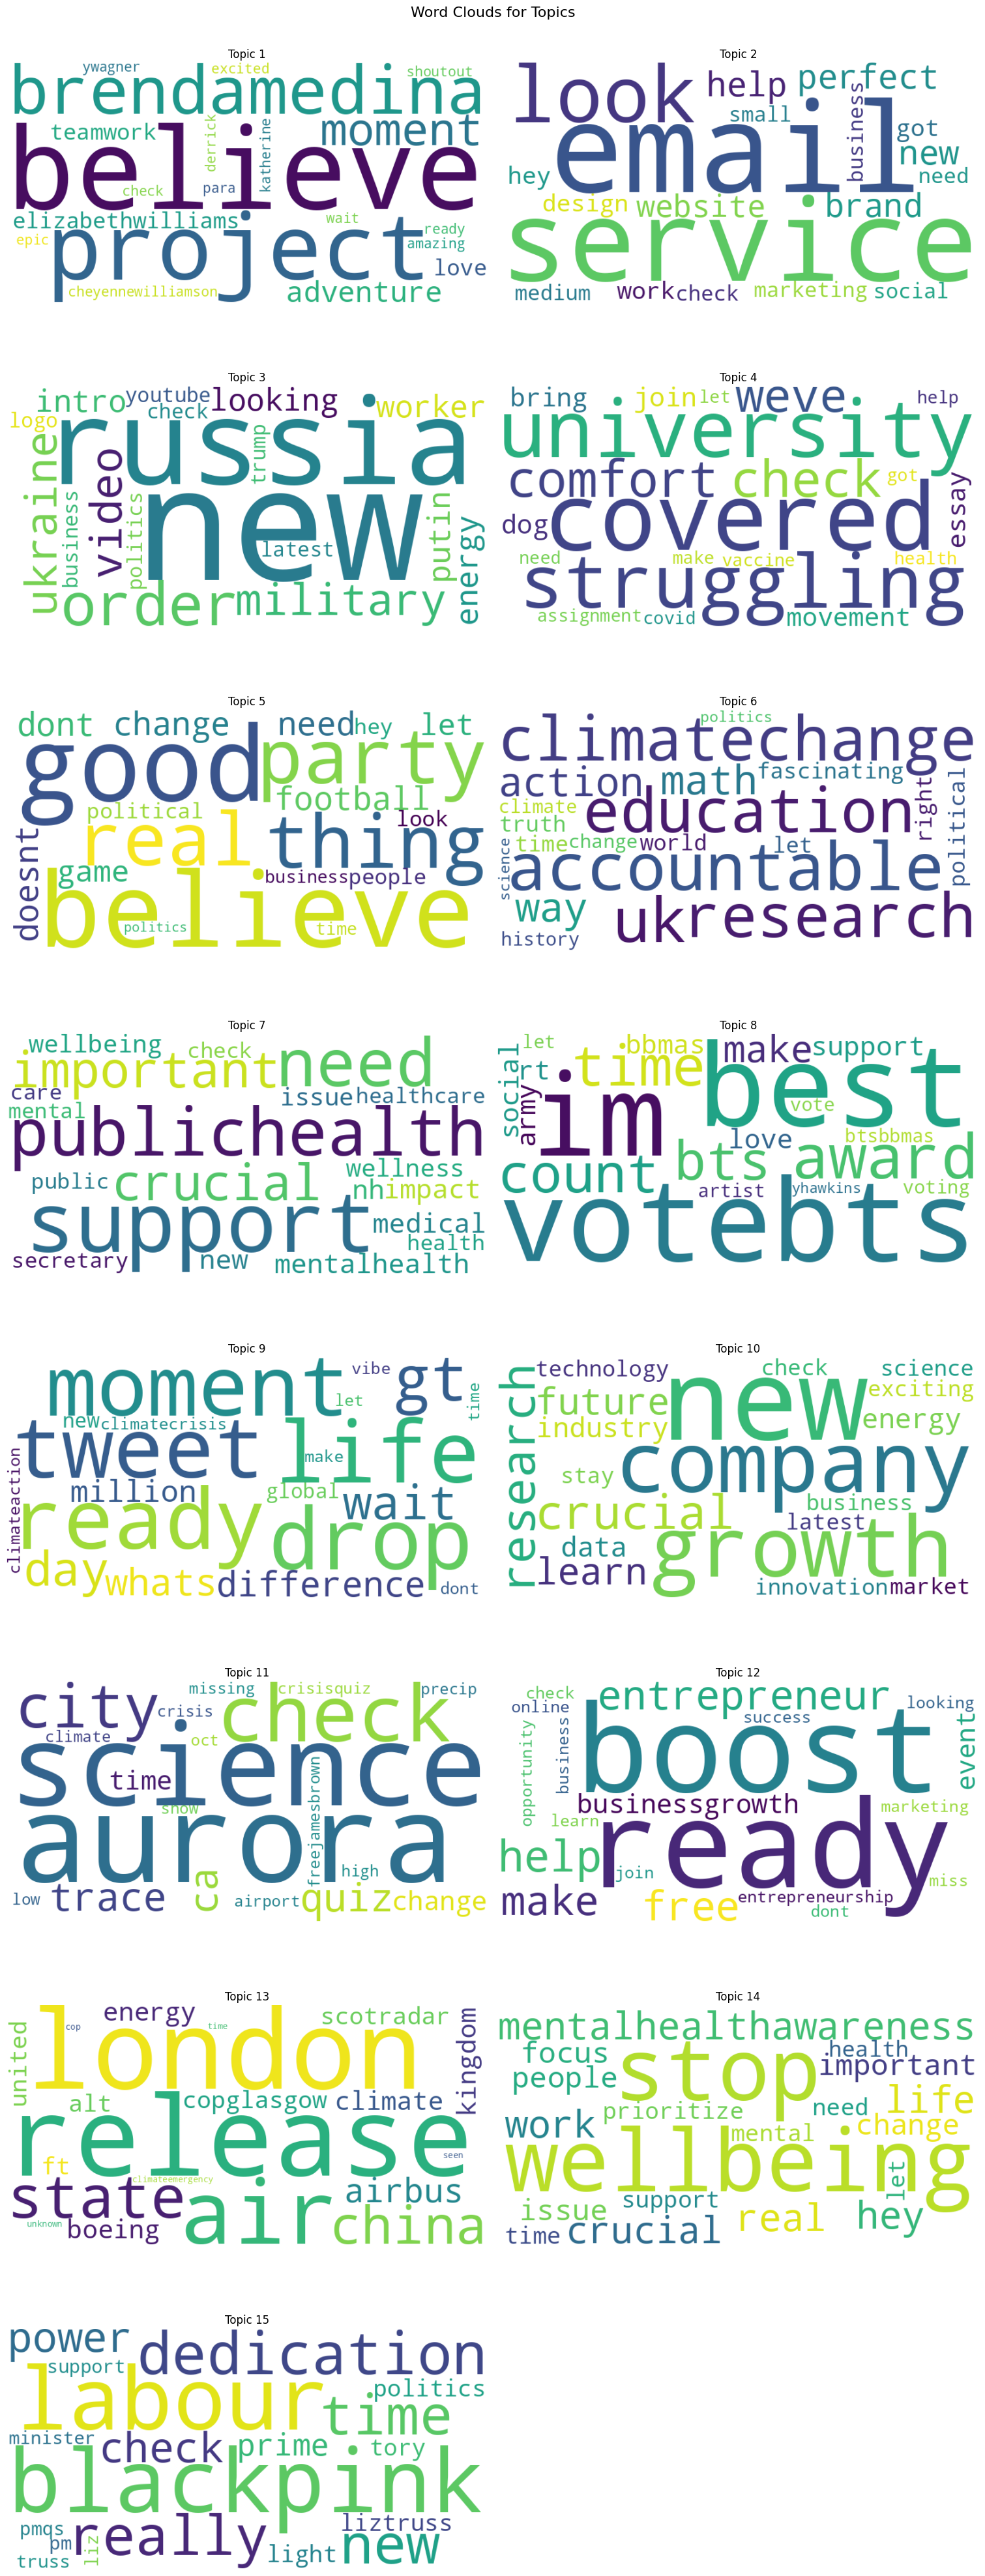

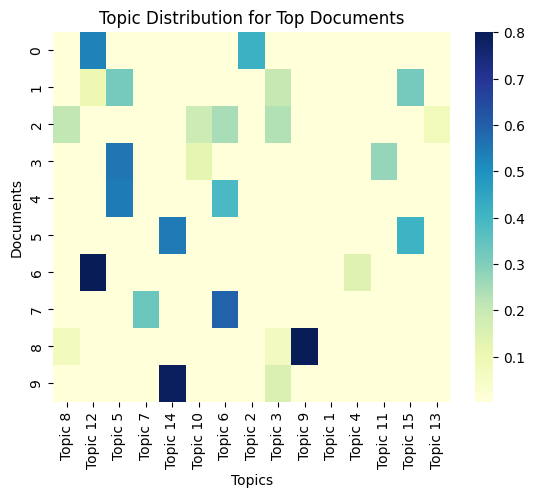

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns

# Function to create word clouds for each topic
def visualize_wordclouds(lda_model, feature_names, num_words=20):
    """
    Visualize word clouds for each topic in the LDA model.
    """
    cols = 2  # Number of columns in the grid
    rows = int(np.ceil(lda_model.n_components / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-num_words:]]
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].axis('off')
        axes[topic_idx].set_title(f"Topic {topic_idx + 1}")

    for i in range(len(lda_model.components_), len(axes)):
        fig.delaxes(axes[i])  # Remove empty subplots

    plt.suptitle('Word Clouds for Topics', fontsize=16)
    plt.show()

# Function to create a heatmap for topic distribution
def visualize_topic_distribution(lda_model, doc_term_matrix, num_topics=5, top_documents=10):
    """
    Visualize the topic distribution as a heatmap.
    """
    topic_distributions = lda_model.transform(doc_term_matrix)  # Document-topic matrix
    df_topic_distributions = pd.DataFrame(topic_distributions, columns=[f"Topic {i + 1}" for i in range(num_topics)])
    
    # Sum of contributions of all documents to each topic
    topic_contributions = df_topic_distributions.sum(axis=0)
    sorted_topics = topic_contributions.sort_values(ascending=False).index.tolist()
    df_topic_distributions = df_topic_distributions[sorted_topics]

    # Select top N documents for visualization
    df_top_docs = df_topic_distributions.head(top_documents)
    sns.heatmap(df_top_docs, annot=False, cmap="YlGnBu", cbar=True)
    plt.title('Topic Distribution for Top Documents')
    plt.xlabel('Topics')
    plt.ylabel('Documents')
    plt.show()

# Visualize topics using word clouds
visualize_wordclouds(best_model, feature_names, num_words=20)

# Visualize topic distribution as a heatmap
visualize_topic_distribution(best_model, doc_term_matrix, num_topics=best_model.n_components, top_documents=10)

In [88]:
# import pyLDAvis
# import pyLDAvis.sklearn_models  # Correct for pyLDAvis 3.4.0
# import matplotlib.pyplot as plt

# # Visualize the best model's topics using pyLDAvis
# lda_visualization = pyLDAvis.sklearn_models.prepare(best_model, doc_term_matrix, vectorizer)

# # Display the visualization
# pyLDAvis.display(lda_visualization)

Topics
- Topic 0: business updates, science-related discussions, or climate topics
- Topic 1: social movements, voting, and fandom-related activities
- Topic 2: political and climate-related discussions
- Topic 3: self-improvement, business, or political discussions
- Topic 4: healthcare and mental health advocacy

Topic overlap: voting in topic 1 and political discussions in topic 2 + topic 3 and 0 both have business topics 

Topic overlap could be caused by ambiguity of words, e.g., "voting" might refer to an artist poll or social media engagement in topic 1 rather than a political election. Or the choice of number of topics (`n_components`) is not ideal.

Themes 
- Environmental and climate concerns (Topics 0, 2)
- Social movements and fandoms (Topic 1)
- Business and self-improvement (Topics 0, 3)
- Mental health and healthcare advocacy (Topic 4)

-> societal, individual, and collective interests

### Named Entity Recognition

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

# Define a function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Preprocess the text column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Convert the text df into a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=4, random_state=42)  # Specify number of topics (n_components)
lda.fit(doc_term_matrix)

# Get the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[-num_top_words:]]))

# Display topics
num_top_words = 10  # Number of top words to display per topic
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, num_top_words)

[nltk_data] Downloading package stopwords to /Users/leori/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0:
learn, miss, dont, latest, new, join, science, health, check, business
Topic 1:
voting, btsbbmas, artist, love, support, social, health, lets, vote, yhawkins
Topic 2:
lets, new, times, healthcare, people, change, like, time, health, politics
Topic 3:
31, oct, 00, like, climate, low, politics, high, hey, business


### Named Entity Recognition

**Named Entity Recognition (NER)** identifies and classifies named entities such as people, organizations, locations, dates, and other predefined categories within text.

**Significance**: NER enables text analytics by extracting structured information from unstructured data, supporting applications like information retrieval, customer sentiment analysis, and knowledge graph construction.

In [ ]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy
from collections import Counter

# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Define a function to perform NER on text
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply NER to the 'text' column
df['entities'] = df['text'].apply(extract_entities)

# Extract and count entities by type
all_entities = sum(df['entities'], [])  # Flatten the list of entities
entity_counter = Counter([entity[1] for entity in all_entities])
print("\nEntity Type Counts:")
print(entity_counter)

# Extract most common entities
most_common_entities = Counter(list(all_entities)).most_common(10)
print("\nMost Common Entities:")
print(most_common_entities)


Entity Type Counts:
Counter({'PERSON': 21630, 'CARDINAL': 17724, 'DATE': 14083, 'GPE': 11805, 'ORG': 11399, 'NORP': 4302, 'PRODUCT': 2512, 'ORDINAL': 1729, 'TIME': 1490, 'LOC': 838, 'QUANTITY': 792, 'FAC': 364, 'MONEY': 242, 'LANGUAGE': 179, 'WORK_OF_ART': 72, 'EVENT': 70, 'LAW': 44, 'PERCENT': 26})

Most Common Entities:
[(('today', 'DATE'), 1172), (('oct 31', 'DATE'), 1170), (('first', 'ORDINAL'), 847), (('one', 'CARDINAL'), 607), (('00', 'CARDINAL'), 575), (('1', 'CARDINAL'), 566), (('2', 'CARDINAL'), 494), (('3', 'CARDINAL'), 490), (('india', 'GPE'), 440), (('uk', 'GPE'), 437)]


In [ ]:
def filter_entities_by_type(entities, entity_type):
    return [entity[0] for entity in entities if entity[1] == entity_type]

df['people'] = df['entities'].apply(lambda ents: filter_entities_by_type(ents, 'PERSON'))
df['organizations'] = df['entities'].apply(lambda ents: filter_entities_by_type(ents, 'ORG'))
df['locations'] = df['entities'].apply(lambda ents: filter_entities_by_type(ents, 'GPE'))

- PERSON (21,630): Most identified entities are names of people, suggesting the text may heavily involve personal mentions.
- CARDINAL (17,724): Numbers (like counts, rankings, etc.) are frequently mentioned, indicating numeric data is common.
- DATE (14,083): Numerous dates are referenced, which may indicate time-based content like schedules, historical references, or event details.
- GPE (11,805): Locations such as cities or countries are commonly mentioned, pointing to geographical or regional significance.
- ORG (11,399): Organizations are prevalent, suggesting the text discusses institutions like companies or groups.
- Entities with smaller counts (e.g., MONEY, PERCENT) indicate less focus on financial or statistical data, while entities like LAW or WORK_OF_ART suggest fewer references to legal terms or creative works.

### Sentiment Analysis

sentiment
positive    47164
negative    14464
neutral      8632
Name: count, dtype: int64


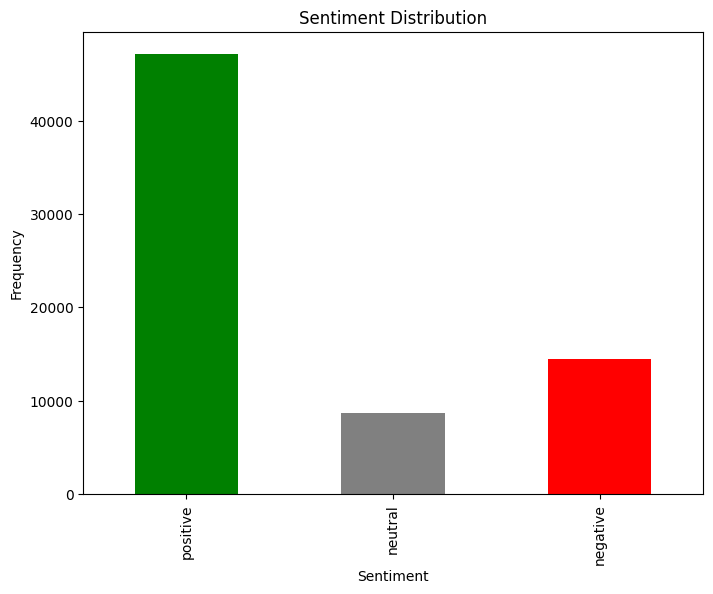

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment
def analyze_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    # Determine sentiment as positive, neutral, or negative
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the 'text' column
df['sentiment'] = df['text'].apply(analyze_sentiment)

# Output the distribution of sentiments
print(df['sentiment'].value_counts())

# Visualize sentiment distribution
import matplotlib.pyplot as plt
# Ensure the sentiment categories are ordered
sentiment_counts = df['sentiment'].value_counts()
ordered_sentiments = ['positive', 'neutral', 'negative']
sentiment_counts = sentiment_counts.reindex(ordered_sentiments)

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

### Duplicate Posts

In [ ]:
# Total number of posts in cleaned_text
total_posts = len(df['text'])

# Number of unique posts in cleaned_text
unique_posts = df['text'].nunique()

# Number of exact duplicate posts
duplicate_posts = total_posts - unique_posts

# Check if numbers add up
if total_posts == unique_posts + duplicate_posts:
    print("The total number of posts is consistent with unique and duplicate counts.")
else:
    print("There is a discrepancy in the counts.")

# Print the results
print(f"Total posts: {total_posts}")
print(f"Unique posts: {unique_posts}")
print(f"Duplicate posts: {duplicate_posts}")
print(f"{round(100*duplicate_posts/total_posts,2)}% of posts are duplicates")


The total number of posts is consistent with unique and duplicate counts.
Total posts: 70260
Unique posts: 47160
Duplicate posts: 23100
32.88% of posts are duplicates


# User Analysis

In [ ]:
from collections import defaultdict

# Step 1: Group posts by their cleaned_text
df_sorted = df.sort_values(by='text')  # Sorting by cleaned_text
grouped = defaultdict(list)

# Store user_ids for each unique cleaned_text
for _, row in df_sorted.iterrows():
    grouped[row['text']].append(row['user_id'])

# Step 2: Find accounts with duplicate posts
duplicate_accounts = []

duplicate_accounts.extend(
    (text, set(user_ids))
    for text, user_ids in grouped.items()
    if len(set(user_ids)) > 1
)
# Step 3: Output results
print(f"{len(duplicate_accounts)} duplicate posts are from multiple accounts")

15770 duplicate posts are from multiple accounts


In [ ]:
# Step 1: Count duplicates for each user
# Count the total occurrences of each post (text)
text_counts = df['text'].value_counts()

# Add a column with the count of each post
df['post_count'] = df['text'].map(text_counts)

# Filter for duplicate posts (occurrences > 1)
duplicates = df[df['post_count'] > 1]

# Group by user_id and count the number of duplicate posts per user
user_duplicates = duplicates.groupby(['user_id', 'user']).size().reset_index(name='duplicate_post_count')

# Step 2: Get the top 10 users with the most duplicate posts
top_duplicate_posters = user_duplicates.sort_values(by='duplicate_post_count', ascending=False).head(10)

# Step 3: Display the results
print("Top 10 users with the most duplicate posts:")
print(top_duplicate_posters)


Top 10 users with the most duplicate posts:
          user_id              user  duplicate_post_count
2620   1010626427          robert78                   233
13528  1055454345      smithcynthia                   115
16582  1068051022      reginabarnes                    86
5313   1021769564         thomasamy                    39
6411   1026359017           karen38                    39
11947  1049045932  patrickrodriguez                    37
13723  1056254952         terrytami                    35
1698   1006790726       hodgesbrian                    35
22066  1090425947            ivan07                    35
13627  1055891373           ycuevas                    35


- User `1010626427` (username "robert78") is an outlier with **$233$ duplicate posts** highlighting the user's disproportionate spam activity.

##### Number of unique users

In [ ]:
# Calculate the number of unique users
unique_users = df['user_id'].nunique()
print(f"Number of unique users: {unique_users}")

Number of unique users: 46755


##### Most active users

In [ ]:
# Identify users with the highest activity
user_activity = df.groupby('user_id').size().reset_index(name='post_count')
top_users = user_activity.sort_values(by='post_count', ascending=False).head(10)
print("Top 10 users with the highest activity:")
print(top_users)

Top 10 users with the highest activity:
          user_id  post_count
4977   1010626427         837
36375  1077881120         178
3600   1007690223         134
14652  1031499948         123
25885  1055454345         116
22969  1049151527         102
38140  1081539622          91
31734  1068051022          86
10609  1022561255          76
3568   1007621559          75


In [ ]:
top_user_id = top_users.iloc[0]["user_id"]
top_username = df.loc[df['user_id'] == top_user_id, 'user'].values[0]
print(f"The most active user is {top_username} ({top_user_id})")

The most active user is robert78 (1010626427)


- User `1010626427` (username "robert78") is an outlier with **$837$ posts**, far exceeding the next most active user with $178$ posts, emphasizing their disproportionate activity.

In [ ]:
user_id = "1010626427"
user_posts = original_posts[original_posts['user_id']==user_id]["text"]
for i in range(100):
    print(user_posts.values[i])

👀✈️🔊G-WYLD  #GWYLD  #Private  #Cessna T210N Turbo Centurion  From: #Unknown To: #Unknown Alt 2050ft  #40133E   Seen 15 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow https://t.co/N4T5eWLQVB
👀✈️🔊N807AA  #AAL203  #American Airlines  #Boeing 787 8  From: #AMS Amsterdam Airport Schiphol, Netherlands To: #PHL Philadelphia, United States Alt 39975ft  #AAFBDF   Seen 13 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow https://t.co/0wRuSQ3iPA
👀✈️🔊G-SAJL  #LOG77A  #Loganair  #Embraer ERJ-145 EP  From: #NWI Norwich, United Kingdom To: #ABZ Aberdeen Dyce, United Kingdom Alt 24000ft  #4007DA   Seen 559 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow
👀✈️🔊G-PDGV  #Unknown  #PLM Dollar Group  #VulcanAir P.68 TC  From: #Unknown To: #Unknown Alt 6350ft  #40752F   Seen 21 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow
👀✈️🔊EI-DVL  #EIN317  #Aer Lingus  #Airbus A320 214  From: #EDI Edinburgh, United Kingdom To: #BHD George Best Belfast City, United Kingdom Alt 4900f

### Network Analysis

In [ ]:
import networkx as nx

# Load the graph data
graph_data = pd.read_csv("./data/graph.csv")

# Create an undirected graph using the source and target columns
G = nx.from_pandas_edgelist(graph_data, source='source', target='target')

##### Degree Centrality

Degree centrality quantifies the proportion of users a given user is directly connected to, representing their level of **direct influence or reach** in the network.

In social media analysis, users with high degree centrality are **key influencers or hubs** who can quickly disseminate information to many others, making them critical in campaigns, trends, or spreading information.

count    46849.000000
mean         0.000086
std          0.000195
min          0.000021
25%          0.000043
50%          0.000064
75%          0.000085
max          0.038145
dtype: float64


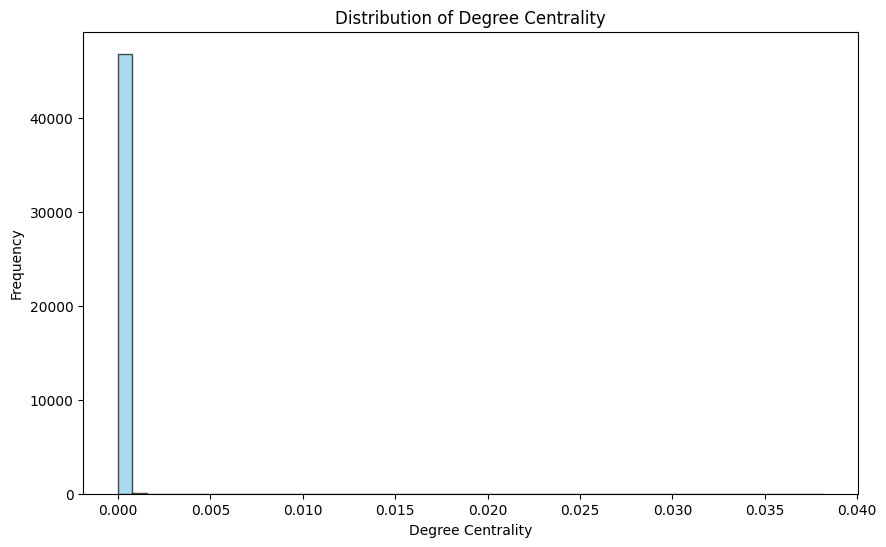

In [ ]:
# calculate degree centrality for all users
degree_centrality = nx.degree_centrality(G)
# analyze the distribution of degree centrality
centrality_scores = pd.Series(degree_centrality.values())
print(centrality_scores.describe())

plt.figure(figsize=(10, 6))
plt.hist(centrality_scores, bvins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.show()

In [ ]:
avg_degree_centrality = centrality_scores.mean()
print(f"Average Degree Centrality: {avg_degree_centrality}")

Average Degree Centrality: 8.64632588340147e-05


- The network is highly sparse, as the degree centrality distribution shows that most users have extremely low centrality scores (close to 0), with only a few users acting as hubs, indicated by the maximum centrality of 0.0381.
- This sparsity could be because the data basis could be incomplete: It could be a cutout of the complete data by limiting the data export to a specific region for instance.

In [ ]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 users by degree centrality:")
for user, centrality in top_degree_centrality:
    print(f"User: {user}, Centrality: {centrality}")

Top 10 users by degree centrality:
User: 1010626427, Centrality: 0.038144637978142076
User: 1027710225, Centrality: 0.001131318306010929
User: 1018042330, Centrality: 0.0010459357923497269
User: 1030048137, Centrality: 0.0010459357923497269
User: 1084949174, Centrality: 0.0009818989071038251
User: 1066276793, Centrality: 0.0009818989071038251
User: 1090990902, Centrality: 0.0009818989071038251
User: 1059101695, Centrality: 0.0009818989071038251
User: 1047703640, Centrality: 0.0009605532786885246
User: 1004360689, Centrality: 0.0009178620218579235


- User `1010626427` stands out as a major hub, being directly connected (friends) to approximately $3.81\%$ of all users, while the rest of the top 10 users have significantly lower centrality, indicating a highly uneven distribution of connections.

##### Clustering Coefficients

The clustering coefficient measures the likelihood that a user's connections (friends or followers) are also connected to one another, highlighting the local interconnectedness or "tight-knit" groups in the network.

Significance: A high clustering coefficient in social media networks indicates the presence of communities or echo chambers, where users are part of closely-knit groups, fostering information flow or reinforcing specific opinions within those groups.

In [ ]:
# Calculate clustering coefficients
clustering_coefficients = nx.clustering(G)
avg_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)
print(f"Average clustering coefficient: {avg_clustering_coefficient}")

Average clustering coefficient: 0.10242240045186507


 - On average, about $10.24\%$ of a user's neighbors are also connected to each other, suggesting that the network exhibits a relatively low level of local connectivity or clustering.

##### Closeness and Betweenness Centrality

Closeness centrality measures how quickly a user can reach all other users in the network, based on the shortest paths from that user to others.

Significance: In social media analysis, users with high closeness centrality can efficiently spread information or ideas, making them influential in rapidly propagating trends or news.


Betweenness centrality quantifies how often a user acts as a bridge between other users, based on the shortest paths passing through them.

Significance: Users with high betweenness centrality are critical intermediaries in the network, enabling the flow of information between otherwise disconnected groups and often acting as gatekeepers or brokers.

In [ ]:
# Closeness centrality
closeness_centrality = nx.closeness_centrality(G)
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 users by closeness centrality:")
for user, centrality in top_closeness:
    print(f"User: {user}, Centrality: {centrality}")

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 users by betweenness centrality:")
for user, centrality in top_betweenness:
    print(f"User: {user}, Centrality: {centrality}")


Top 10 users by closeness centrality:
User: 1010626427, Centrality: 0.30633022303884705
User: 1077997466, Centrality: 0.2364615563216418
User: 1021402235, Centrality: 0.2362290485891204
User: 1028635896, Centrality: 0.23563377377186057
User: 1043529958, Centrality: 0.23560296314177517
User: 1089906253, Centrality: 0.23549163805626908
User: 1001396520, Centrality: 0.23531420936575467
User: 1076700886, Centrality: 0.23517600048191803
User: 1032319872, Centrality: 0.23507569409249884
User: 1032811749, Centrality: 0.23505918124664454

Top 10 users by betweenness centrality:
User: 1010626427, Centrality: 0.9896298288685079
User: 1038230812, Centrality: 0.0070046515806957525
User: 1077997466, Centrality: 0.006013904448260786
User: 1019871970, Centrality: 0.005927335450255653
User: 1032319872, Centrality: 0.005910679364671109
User: 1075438118, Centrality: 0.005775643947694998
User: 1001396520, Centrality: 0.005432906779826888
User: 1037467053, Centrality: 0.005375260064014553
User: 104697458

- User `1010626427` is the most central in the network, with the highest closeness centrality ($0.3063$) for efficiently reaching others and an overwhelmingly high betweenness centrality ($0.9896$), indicating a critical role as a bridge connecting otherwise separate groups.

TODO: Community detection?